<a href="https://colab.research.google.com/github/dhia-eddine-jedidi/Sentiment-Analysis-Using-Bertweet-and-Graph--Rag/blob/main/Graph_Rag_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This folder should now exist after the unzip command above.
BERT_PATH = "bertweet_finetuned"

tokenizer = AutoTokenizer.from_pretrained(BERT_PATH, use_fast=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_PATH,
    output_hidden_states=True  # we want CLS embeddings
).to(device)

bert_model.eval()
print("Loaded fine-tuned BERTweet from:", BERT_PATH)


In [2]:
!pip install torch torchvision torchaudio torch-geometric transformers pandas tqdm scikit-learn

import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv, Linear



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [19]:
# ============================================================
# 1. LOAD SENTIMENT140 DATA
# ============================================================
# Default columns for training.1600000.processed.noemoticon.csv
cols = ["target", "id", "date", "query", "user", "text"]

df = pd.read_csv(
    "/content/drive/MyDrive/Copie de training.1600000.processed.noemoticon.csv",
    encoding="latin1",
    names=cols
)

print("Total tweets in file:", len(df))
print(df.head())

print("Total tweets in file:", len(df))


Total tweets in file: 1600000
   target          id                          date     query  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Total tweets in file: 1600000


In [8]:
# Your zip is in the current session as: bertweet_finetuned-ZIP.zip
# This will extract it in the current working directory.
!unzip -q bertweet_finetuned-ZIP.zip


In [20]:
# This folder should now exist after the unzip command above.
BERT_PATH = "bertweet_finetuned"

tokenizer = AutoTokenizer.from_pretrained(BERT_PATH, use_fast=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_PATH,
    output_hidden_states=True  # we want CLS embeddings
).to(device)

bert_model.eval()
print("Loaded fine-tuned BERTweet from:", BERT_PATH)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Loaded fine-tuned BERTweet from: bertweet_finetuned


In [21]:
def encode_batch(texts, max_length=64):
    """
    Encode a batch of texts with your fine-tuned BERTweet:
    returns CLS embeddings and sentiment probabilities.
    """
    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        out = bert_model(**enc)

    # sentiment probabilities [B, num_labels] (num_labels = 3 here)
    probs = out.logits.softmax(dim=-1).cpu().numpy()

    # CLS embeddings from last hidden state [B, hidden_dim]
    last_hidden = out.hidden_states[-1]  # [B, seq, hidden]
    cls_emb = last_hidden[:, 0, :].cpu().numpy()

    return cls_emb, probs



In [22]:
# ============================================================
# 3. GENERATE TWEET EMBEDDINGS + SENTIMENT PROBS
# ============================================================
batch_size = 64

all_cls = []
all_probs = []

print("Encoding tweets with fine-tuned BERTweet...")
for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df["text"].iloc[i:i+batch_size].tolist()
    cls, probs = encode_batch(batch_texts)
    all_cls.append(cls)
    all_probs.append(probs)

tweet_cls = np.concatenate(all_cls, axis=0)      # [N, hidden_dim]
tweet_probs = np.concatenate(all_probs, axis=0)  # [N, 3] (neg/neu/pos from your model)

print("tweet_cls shape:", tweet_cls.shape)
print("tweet_probs shape:", tweet_probs.shape)

# Final tweet features = CLS embedding + probabilities  -> dim = hidden_dim + 3
tweet_features = np.concatenate([tweet_cls, tweet_probs], axis=1)
tweet_features_tensor = torch.tensor(tweet_features, dtype=torch.float)
print("tweet_features_tensor:", tweet_features_tensor.shape)



Encoding tweets with fine-tuned BERTweet...


100%|██████████| 25000/25000 [30:44<00:00, 13.55it/s]


tweet_cls shape: (1600000, 768)
tweet_probs shape: (1600000, 3)
tweet_features_tensor: torch.Size([1600000, 771])


In [23]:
# ============================================================
# 4. BUILD USER NODES + FEATURES
# ============================================================
# Map each user (string) to an integer index
users = df["user"].astype(str).unique()
user2idx = {u: i for i, u in enumerate(users)}
idx2user = {i: u for u, i in user2idx.items()}
num_users = len(users)
num_tweets = len(df)

print("num_users:", num_users)
print("num_tweets:", num_tweets)

# Group tweets per user
user_tweet_indices = {u: [] for u in users}
for i, u in enumerate(df["user"].astype(str)):
    user_tweet_indices[u].append(i)

# Build user features by aggregating tweet embeddings and sentiment probs
user_features = []

for u in users:
    idxs = user_tweet_indices[u]
    # mean CLS embedding [hidden_dim]
    emb_mean = tweet_cls[idxs].mean(axis=0)
    # mean sentiment probabilities [3]
    sent_mean = tweet_probs[idxs].mean(axis=0)
    # tweet count (scalar)
    count = len(idxs)

    feat = np.concatenate([emb_mean, sent_mean, [count]], axis=0)  # [hidden_dim + 4]
    user_features.append(feat)

user_features = np.stack(user_features, axis=0)
user_features_tensor = torch.tensor(user_features, dtype=torch.float)
print("user_features_tensor:", user_features_tensor.shape)


num_users: 659775
num_tweets: 1600000
user_features_tensor: torch.Size([659775, 772])


In [24]:
# ============================================================
# 5. BUILD GRAPH EDGES (AUTHORED + MENTIONS)
# ============================================================
# 5.1 Authorship edges: user -> tweet
auth_edges = []

for tweet_idx, row in df.iterrows():
    u_idx = user2idx[str(row["user"])]
    auth_edges.append([u_idx, tweet_idx])

auth_edges = torch.tensor(auth_edges, dtype=torch.long).t().contiguous()
auth_edges_rev = auth_edges.flip(0)  # tweet -> user
print("auth_edges shape:", auth_edges.shape)


# 5.2 Mention edges: user -> user (author mentions someone in text)
mention_edges_list = []

for tweet_idx, row in df.iterrows():
    author = user2idx[str(row["user"])]
    text = str(row["text"])
    mentions = re.findall(r"@([A-Za-z0-9_]+)", text)

    for m in mentions:
        if m in user2idx:
            mentioned = user2idx[m]
            mention_edges_list.append([author, mentioned])

if len(mention_edges_list) == 0:
    mention_edges = torch.empty((2, 0), dtype=torch.long)
    mention_edges_rev = torch.empty((2, 0), dtype=torch.long)
else:
    mention_edges = torch.tensor(mention_edges_list, dtype=torch.long).t().contiguous()
    mention_edges_rev = mention_edges.flip(0)

print("mention_edges shape:", mention_edges.shape)

auth_edges shape: torch.Size([2, 1600000])
mention_edges shape: torch.Size([2, 395351])


In [25]:
from sklearn.cluster import KMeans


# ============================================================
# 6. BUILD HETERODATA GRAPH
# ============================================================
data = HeteroData()

data["tweet"].x = tweet_features_tensor
data["user"].x = user_features_tensor

data["user", "authored", "tweet"].edge_index = auth_edges
data["tweet", "rev_authored", "user"].edge_index = auth_edges_rev
data["user", "mentions", "user"].edge_index = mention_edges
data["user", "mentioned_by", "user"].edge_index = mention_edges_rev

print(data)


# ============================================================
# 7. USER LABELS FOR GNN (SENTIMENT)
# ============================================================
# Map Sentiment140: 0 -> 0 (neg), 4 -> 2 (pos)
raw_targets = df["target"].values
tweet_labels = np.zeros_like(raw_targets)
tweet_labels[raw_targets == 4] = 2
num_classes = 3

user_y_sent = np.full(num_users, -1, dtype=np.int64)

for u in users:
    idxs = user_tweet_indices[u]
    lbls = tweet_labels[idxs]
    if len(lbls) == 0:
        continue
    counts = np.bincount(lbls, minlength=num_classes)
    total = counts.sum()
    major = counts.argmax()
    if total > 0 and counts[major] / total >= 0.6:
        user_y_sent[user2idx[u]] = major

data["user"].y_sent = torch.tensor(user_y_sent, dtype=torch.long)

labeled_mask_np = (user_y_sent != -1)
labeled_indices = np.where(labeled_mask_np)[0]
np.random.shuffle(labeled_indices)

train_size = int(0.7 * len(labeled_indices))
val_size = int(0.15 * len(labeled_indices))

train_idx = labeled_indices[:train_size]
val_idx = labeled_indices[train_size:train_size+val_size]
test_idx = labeled_indices[train_size+val_size:]

train_mask = np.zeros(num_users, dtype=bool)
val_mask = np.zeros(num_users, dtype=bool)
test_mask = np.zeros(num_users, dtype=bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data["user"].train_mask = torch.tensor(train_mask, dtype=torch.bool)
data["user"].val_mask   = torch.tensor(val_mask, dtype=torch.bool)
data["user"].test_mask  = torch.tensor(test_mask, dtype=torch.bool)

print("Labeled users:", labeled_mask_np.sum())
print("Train:", train_mask.sum(), "Val:", val_mask.sum(), "Test:", test_mask.sum())


# ============================================================
# 8. HETEROGNN MODEL (USING HeteroConv + GATConv, NO SELF-LOOPS)
# ============================================================
class HeteroGNN(nn.Module):
    def __init__(self, in_user, in_tweet, hidden=64, num_classes=3):
        super().__init__()

        self.lin_user  = Linear(in_user, hidden)
        self.lin_tweet = Linear(in_tweet, hidden)

        # IMPORTANT: add_self_loops=False for all GATConv
        self.conv1 = HeteroConv({
            ('user','authored','tweet'):     GATConv(hidden, hidden, add_self_loops=False),
            ('tweet','rev_authored','user'): GATConv(hidden, hidden, add_self_loops=False),
            ('user','mentions','user'):      GATConv(hidden, hidden, add_self_loops=False),
            ('user','mentioned_by','user'):  GATConv(hidden, hidden, add_self_loops=False),
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('user','authored','tweet'):     GATConv(hidden, hidden, add_self_loops=False),
            ('tweet','rev_authored','user'): GATConv(hidden, hidden, add_self_loops=False),
            ('user','mentions','user'):      GATConv(hidden, hidden, add_self_loops=False),
            ('user','mentioned_by','user'):  GATConv(hidden, hidden, add_self_loops=False),
        }, aggr='sum')

        self.head = Linear(hidden, num_classes)

    def forward(self, data):
        x_dict = {
            "user":  self.lin_user(data["user"].x),
            "tweet": self.lin_tweet(data["tweet"].x),
        }

        x_dict = self.conv1(x_dict, data.edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        x_dict = self.conv2(x_dict, data.edge_index_dict)

        user_emb = x_dict["user"]
        logits = self.head(user_emb)
        return logits, user_emb


# ============================================================
# 9. TRAIN GNN
# ============================================================
data = data.to(device)

model = HeteroGNN(
    in_user=data["user"].x.size(-1),
    in_tweet=data["tweet"].x.size(-1),
    hidden=64,
    num_classes=3
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

y_sent = data["user"].y_sent
train_mask = data["user"].train_mask
val_mask   = data["user"].val_mask

print("Starting GNN training...")

for epoch in range(50):  # fewer epochs for speed
    model.train()
    optimizer.zero_grad()

    logits, user_emb = model(data)

    loss = F.cross_entropy(logits[train_mask], y_sent[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = logits.argmax(dim=-1)
        val_acc = (preds[val_mask] == y_sent[val_mask]).float().mean().item()

    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")


# ============================================================
# 10. EXTRACT USER EMBEDDINGS, INFLUENCE & COMMUNITIES
# ============================================================
model.eval()
with torch.no_grad():
    _, user_emb = model(data)

user_emb = user_emb.cpu().numpy()

# 10.1 Communities via K-Means over user embeddings
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
communities = kmeans.fit_predict(user_emb)

print("Example: first 10 users & their community id:")
for i in range(10):
    print(i, idx2user[i], "-> community", communities[i])


# 10.2 Simple influence score via mention in-degree
if mention_edges.size(1) > 0:
    in_degree = np.bincount(mention_edges[1].cpu().numpy(), minlength=num_users)
else:
    in_degree = np.zeros(num_users, dtype=int)

top_k = 20
top_influencers = np.argsort(-in_degree)[:top_k]

print("\nTop influencers by mention in-degree:")
for idx in top_influencers:
    print(
        f"User idx={idx:5d} | name={idx2user[idx]:20s} | mentions={in_degree[idx]}"
    )

print("\nPipeline complete: BERTweet -> Graph -> HeteroGNN (no self-loops) -> Influence & Communities.")

HeteroData(
  tweet={ x=[1600000, 771] },
  user={ x=[659775, 772] },
  (user, authored, tweet)={ edge_index=[2, 1600000] },
  (tweet, rev_authored, user)={ edge_index=[2, 1600000] },
  (user, mentions, user)={ edge_index=[2, 395351] },
  (user, mentioned_by, user)={ edge_index=[2, 395351] }
)
Labeled users: 607071
Train: 424949 Val: 91060 Test: 91062
Starting GNN training...
Epoch 01 | Loss: 1.0595 | Val Acc: 0.5861
Epoch 02 | Loss: 0.7991 | Val Acc: 0.8728
Epoch 03 | Loss: 0.6196 | Val Acc: 0.8746
Epoch 04 | Loss: 0.4828 | Val Acc: 0.8795
Epoch 05 | Loss: 0.3840 | Val Acc: 0.8877
Epoch 06 | Loss: 0.3138 | Val Acc: 0.8983
Epoch 07 | Loss: 0.2650 | Val Acc: 0.9074
Epoch 08 | Loss: 0.2333 | Val Acc: 0.9144
Epoch 09 | Loss: 0.2158 | Val Acc: 0.9181
Epoch 10 | Loss: 0.2099 | Val Acc: 0.9192
Epoch 11 | Loss: 0.2116 | Val Acc: 0.9180
Epoch 12 | Loss: 0.2166 | Val Acc: 0.9174
Epoch 13 | Loss: 0.2217 | Val Acc: 0.9171
Epoch 14 | Loss: 0.2255 | Val Acc: 0.9175
Epoch 15 | Loss: 0.2281 | Val Acc

Starting GNN training...
Epoch 01 | Loss: 0.2029 | Val Acc: 0.9199
Epoch 02 | Loss: 0.2028 | Val Acc: 0.9199
Epoch 03 | Loss: 0.2028 | Val Acc: 0.9199
Epoch 04 | Loss: 0.2028 | Val Acc: 0.9199
Epoch 05 | Loss: 0.2027 | Val Acc: 0.9199
Epoch 06 | Loss: 0.2027 | Val Acc: 0.9199
Epoch 07 | Loss: 0.2026 | Val Acc: 0.9199
Epoch 08 | Loss: 0.2026 | Val Acc: 0.9200
Epoch 09 | Loss: 0.2026 | Val Acc: 0.9199
Epoch 10 | Loss: 0.2026 | Val Acc: 0.9199
Epoch 11 | Loss: 0.2026 | Val Acc: 0.9200
Epoch 12 | Loss: 0.2025 | Val Acc: 0.9199
Epoch 13 | Loss: 0.2025 | Val Acc: 0.9199
Epoch 14 | Loss: 0.2025 | Val Acc: 0.9199
Epoch 15 | Loss: 0.2024 | Val Acc: 0.9199
Epoch 16 | Loss: 0.2024 | Val Acc: 0.9200
Epoch 17 | Loss: 0.2024 | Val Acc: 0.9200
Epoch 18 | Loss: 0.2023 | Val Acc: 0.9200
Epoch 19 | Loss: 0.2023 | Val Acc: 0.9200
Epoch 20 | Loss: 0.2023 | Val Acc: 0.9199
✅ Saved GNN model to heterognn_sentiment.pt
✅ Saved graph data to hetero_graph_data.pt


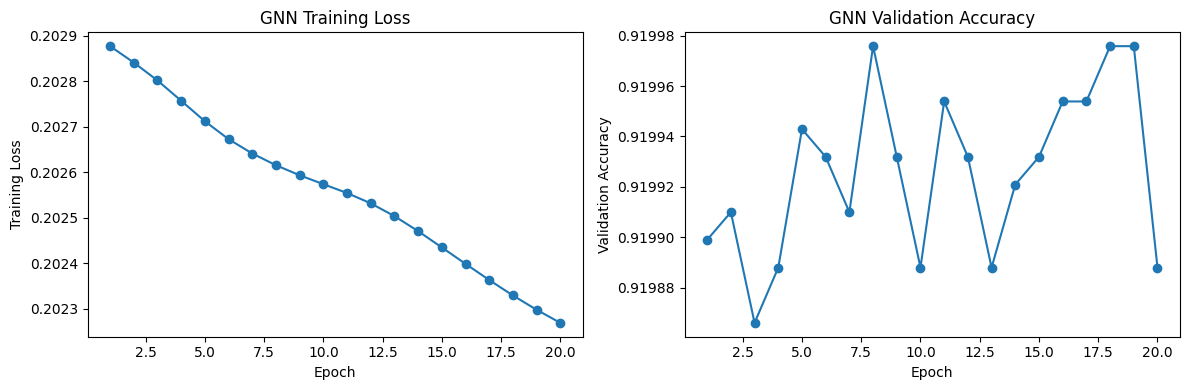

🧪 Test Accuracy: 0.9208

🔹 Example: first 10 users & their community id:
0 _TheSpecialOne_ -> community 3
1 scotthamilton -> community 1
2 mattycus -> community 1
3 ElleCTF -> community 1
4 Karoli -> community 7
5 joy_wolf -> community 4
6 mybirch -> community 9
7 coZZ -> community 9
8 2Hood4Hollywood -> community 1
9 mimismo -> community 3

👑 Top influencers by mention in-degree:
User idx=124405 | name=tommcfly             | mentions=3887
User idx=125582 | name=ddlovato             | mentions=3467
User idx=316616 | name=DavidArchie          | mentions=1299
User idx=592676 | name=DonnieWahlberg       | mentions=1104
User idx=151362 | name=selenagomez          | mentions=801
User idx=57654 | name=shaundiviney         | mentions=511
User idx=126383 | name=YoungQ               | mentions=507
User idx=537359 | name=iamdiddy             | mentions=398
User idx=463284 | name=officialTila         | mentions=390
User idx=232941 | name=ashleytisdale        | mentions=386
User idx=197409 | name=

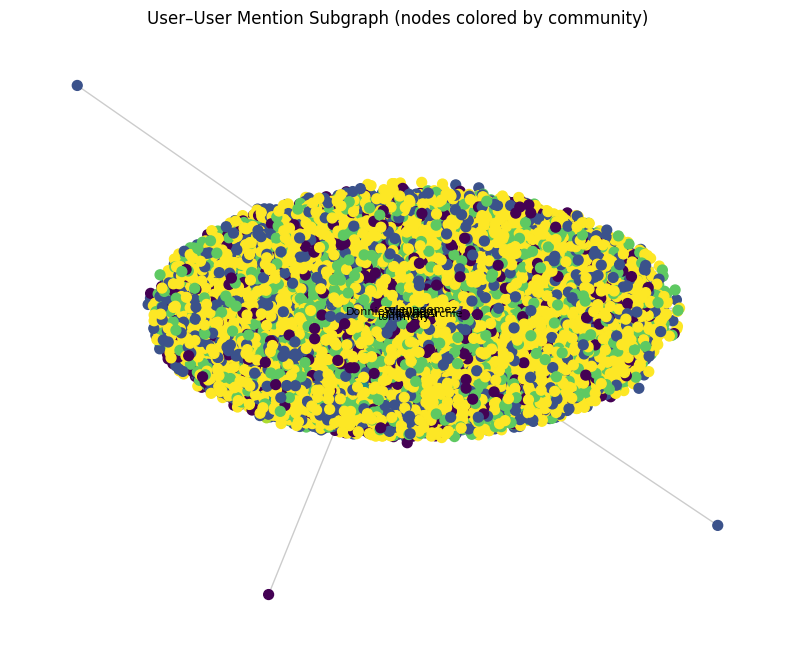


✅ Done: model saved, performance plotted, communities & influence computed, subgraph visualized.


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

# ============================
# TRAIN GNN + TRACK METRICS
# ============================

# make sure graph is on the same device as the model
data = data.to(device)

print("Starting GNN training...")

num_epochs   = 20  # adjust as you like (e.g. 5, 10, 20)
train_losses = []
val_accs     = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    logits, user_emb = model(data)

    loss = F.cross_entropy(logits[train_mask], y_sent[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        preds   = logits.argmax(dim=-1)
        val_acc = (preds[val_mask] == y_sent[val_mask]).float().mean().item()

    train_losses.append(loss.item())
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

# ============================
# SAVE MODEL (AND OPTIONAL GRAPH)
# ============================

# 1) save only the model weights
torch.save(model.state_dict(), "heterognn_sentiment.pt")
print("✅ Saved GNN model to heterognn_sentiment.pt")

# 2) save a CPU copy of the graph WITHOUT touching the original `data`
data_cpu = data.to("cpu")
torch.save(data_cpu, "hetero_graph_data.pt")
print("✅ Saved graph data to hetero_graph_data.pt")


# ============================
# PLOT LOSS & ACCURACY
# ============================

epochs_arr = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_arr, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("GNN Training Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_arr, val_accs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("GNN Validation Accuracy")

plt.tight_layout()
plt.show()

# Optional: test accuracy
# (ensure data is on device before evaluating)
data = data.to(device)
model.eval()
with torch.no_grad():
    logits, _ = model(data)
    preds    = logits.argmax(dim=-1)
    test_acc = (preds[test_mask] == y_sent[test_mask]).float().mean().item()

print(f"🧪 Test Accuracy: {test_acc:.4f}")


# ============================
# COMMUNITIES & INFLUENCE
# ============================

# Get final user embeddings from GNN
data = data.to(device)
model.eval()
with torch.no_grad():
    _, user_emb = model(data)

user_emb = user_emb.cpu().numpy()

# 1) Communities via K-Means
num_clusters = 10
kmeans      = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
communities = kmeans.fit_predict(user_emb)

print("\n🔹 Example: first 10 users & their community id:")
for i in range(10):
    print(i, idx2user[i], "-> community", communities[i])

# 2) Influence via mention in-degree
mention_edges_cpu = data["user", "mentions", "user"].edge_index.cpu()

if mention_edges_cpu.numel() > 0:
    in_degree = np.bincount(
        mention_edges_cpu[1].numpy(),
        minlength=num_users
    )
else:
    in_degree = np.zeros(num_users, dtype=int)

top_k           = 20
top_influencers = np.argsort(-in_degree)[:top_k]

print("\n👑 Top influencers by mention in-degree:")
for idx in top_influencers:
    print(
        f"User idx={idx:5d} | name={idx2user[idx]:20s} | mentions={in_degree[idx]}"
    )


# ============================
# SUBGRAPH VISUALIZATION
# ============================

# Build a small user–user subgraph around top influencers
num_seed   = 30
seed_users = top_influencers[:num_seed]
seed_set   = set(seed_users)

G = nx.DiGraph()

# Add seed nodes
for uidx in seed_users:
    G.add_node(uidx)

src = mention_edges_cpu[0].numpy()
dst = mention_edges_cpu[1].numpy()

# Keep edges where source OR destination is a seed user
for s, d in zip(src, dst):
    if s in seed_set or d in seed_set:
        G.add_edge(s, d)

# Color nodes by community ID
node_colors = [communities[uidx] for uidx in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color=node_colors,
    cmap="viridis"
)
nx.draw_networkx_edges(G, pos, alpha=0.2, arrows=False)

# Label a few strongest influencers for readability
labels = {}
for uidx in seed_users[:5]:
    if uidx in G.nodes():
        labels[uidx] = idx2user[uidx]

nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("User–User Mention Subgraph (nodes colored by community)")
plt.axis("off")
plt.show()

print("\n✅ Done: model saved, performance plotted, communities & influence computed, subgraph visualized.")


In [30]:
import plotly.graph_objects as go
import numpy as np
import networkx as nx

# ============================
# BUILD EGO NETWORK (same logic as before)
# ============================

# choose central influencer (0 = most mentioned)
focus_idx = int(top_influencers[0])   # change index to see another influencer
print("Central user:", focus_idx, idx2user[focus_idx])

src = mention_edges_cpu[0].numpy()
dst = mention_edges_cpu[1].numpy()

max_neighbors = 60   # limit neighbors to keep graph readable
neighbors = set()

for s, d in zip(src, dst):
    if s == focus_idx and len(neighbors) < max_neighbors:
        neighbors.add(d)
    elif d == focus_idx and len(neighbors) < max_neighbors:
        neighbors.add(s)

nodes_sub = {focus_idx} | neighbors

G = nx.DiGraph()
for s, d in zip(src, dst):
    if s in nodes_sub and d in nodes_sub:
        G.add_edge(s, d)

print(f"Subgraph nodes: {len(G.nodes())}, edges: {len(G.edges())}")

# layout positions
pos = nx.spring_layout(G, k=0.4, iterations=80, seed=42)

# ============================
# BUILD PLOTLY TRACES
# ============================

# Edge coordinates
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='rgba(150,150,150,0.4)'),
    hoverinfo='none',
    mode='lines'
)

# Node coordinates + features
node_x, node_y = [], []
node_color = []
node_size  = []
hover_text = []

# label only central user + top few neighbors
deg = dict(G.degree())
neighbors_sorted = sorted(neighbors, key=lambda u: -deg.get(u, 0))[:5]
label_set = {focus_idx} | set(neighbors_sorted)

node_labels = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    node_color.append(int(communities[node]))   # community id
    if node == focus_idx:
        node_size.append(24)  # bigger for center
    else:
        node_size.append(14)

    # hover info
    hover_text.append(
        f"user: {idx2user[node]}<br>"
        f"community: {communities[node]}<br>"
        f"in-degree: {G.in_degree(node)}<br>"
        f"out-degree: {G.out_degree(node)}"
    )

    # text label (only for some nodes)
    if node in label_set:
        node_labels.append(idx2user[node])
    else:
        node_labels.append("")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,
    textposition='top center',
    hoverinfo='text',
    textfont=dict(size=9),
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=node_color,
        size=node_size,
        colorbar=dict(
            thickness=15,
            title='Community ID',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0.5, color='black')
    ),
    hovertext=hover_text
)

# ============================
# FIGURE LAYOUT
# ============================

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title=(
            f"Ego network of user '{idx2user[focus_idx]}'<br>"
            "(neighbors by mentions, color = community ID)"
        ),
        title_x=0.5,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=70),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        template="plotly_white"
    )
)

fig.show()


Central user: 124405 tommcfly
Subgraph nodes: 61, edges: 66
